In [178]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

# Dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(3)

# MODEL CONSTANTS
n_realizations = 10

# MCMC PARAMETERS
num_warmup = 500
num_samples = 1000
num_chains = 4

# TESTING
lams = [5, 1, 1/2, 1/10, 1/10000]
sigma = 0.1
p = 1/2

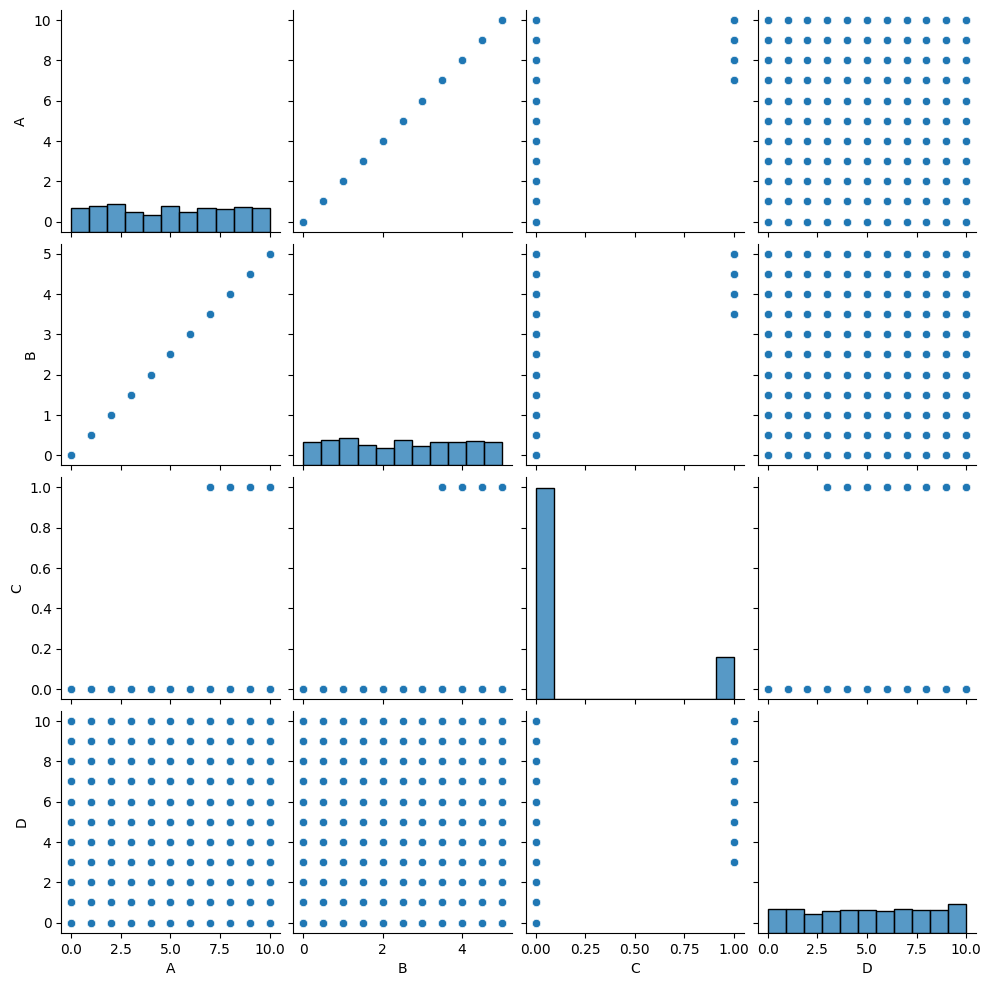

[[ 0.93361271  0.93361271  2.22851792]
 [ 0.62473523  0.62473523 -0.44872872]
 [ 1.24249019  1.24249019 -0.44872872]
 ...
 [-0.91965215 -0.91965215 -0.44872872]
 [ 0.93361271  0.93361271 -0.44872872]
 [-0.61077467 -0.61077467 -0.44872872]] [ 1.5005393   0.26569022 -0.96915886 -1.58658339  1.19182703  1.19182703
 -1.27787113  1.19182703  1.5005393   1.19182703 -1.58658339  0.88311476
 -1.58658339  1.19182703  1.19182703 -0.66044659 -0.96915886  0.88311476
  0.88311476 -1.27787113  1.19182703  0.57440249 -1.58658339 -0.66044659
  1.5005393  -0.04302205 -0.35173432  0.26569022 -0.04302205 -0.96915886
 -1.27787113 -0.66044659 -0.66044659 -0.96915886  0.26569022  0.26569022
  1.5005393  -1.27787113  0.57440249  0.57440249  0.88311476  1.19182703
 -0.35173432 -1.58658339 -0.96915886 -0.35173432 -0.35173432 -1.27787113
 -1.58658339  0.26569022 -1.58658339 -0.66044659  0.57440249  0.57440249
  1.19182703  0.88311476  0.57440249 -0.96915886 -1.58658339  1.19182703
 -0.04302205 -1.27787113 -0.35

In [179]:
# Load data file
dset = pd.read_csv("data/abcd_dag.csv", sep=",")

def standardize(x):
    return (x-x.mean(0)) / x.std(0)

y = dset["D"].values
X = dset[["A", "B", "C"]].values


vars = [
    "A",
    "B",
    "C",
    "D"
]
sns.pairplot(dset, x_vars=vars, y_vars=vars)
plt.show()

X = standardize(X)
y = standardize(y)
print(X, y)


<h2> Defining the Model </h2>

$$\begin{align*} 
y &\sim \text{Bernoulli}(X\gamma) \\

\gamma_j &= \sigma \left(\frac{L_j + \log\alpha_j}{\lambda}\right) \text{  for   } j = 1, ..., D \\
L_j &= \log (U_j) - \log (1-U_j)\\
U_j &\sim \text{Uniform}(0, 1)
\end{align*}$$




Note that in order for the model to work correctly, $\alpha_i$ must be  $\in (0, \infty)$.


In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [180]:
def model(alphas, lam, X, y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter, Dx1
       array X: input data, NxD
       array y: output data, Nx1
    '''
    D = X.shape[1]
    U = numpyro.sample("U", dist.Uniform(0, 1).expand([D])) 
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1 - U)) 
    gammas = numpyro.deterministic("gammas", sigmoid((L + jnp.log(alphas)) / lam)) 
    
    y_mean = jnp.dot(X, gammas) # NxD
    y = numpyro.sample("y", dist.Bernoulli(y_mean), obs=y) 

In [181]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [182]:
def concrete(X, y, lam):
    '''
    Parameters:
       dict all_data: keys are integers and values are the corresponding tuple (X, Y)
       int lam: temperature coefficient
    
    Returns:
       arr mean_gammas: size (D,)
       dict samples: keys are sampled values in the mcmc model, values are the samples
       mcmc: a Numpyro MCMC object

    '''
    alphas = jnp.zeros(X.shape[1])
    alphas += p / (1-p)
    mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, y=y)
    samples = mcmc.get_samples()
    mean_gammas =  samples["gammas"]
   #  plt.figure(figsize=(12, 6))
   #  print(mean_gammas.flatten())
   #  plt.subplot(1, 2, 1)
   #  sns.histplot(mean_gammas.flatten(), kde=True)
   #  plt.title('Distribution of Mean Gammas')

   #  plt.tight_layout()
   #  plt.show()
        
    return mean_gammas, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [183]:
all_mses = dict()
mean_mses = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []
all_data = {}

for _ in range(n_realizations):
    for lam in lams:
        gammas, all_samples, mcmc = concrete(X, y, lam=lam)
        if lam not in mean_gammas:
            mean_gammas[lam] = []
        mean_gammas[lam].append(gammas)
        all_mcmc_runs.append(mcmc)

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_62271/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 2550.96it/s, 3 steps of size 8.01e-02. acc. prob=0.81] 
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_62271/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are availab

The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [184]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.00      0.00      0.00      0.00      0.00     35.43      1.07
      U[1]      0.00      0.00      0.00      0.00      0.00     60.84      1.05
      U[2]      0.85      0.17      0.91      0.60      1.00     52.78      1.04

Number of divergences: 1915

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.02      0.02      0.02      0.00      0.04    463.79      1.00
      U[1]      0.02      0.02      0.02      0.00      0.04    313.13      1.00
      U[2]      0.31      0.02      0.31      0.28      0.35    207.00      1.01

Number of divergences: 877

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.07      0.05      0.07      0.00      0.15    464.09      1.00
      U[1]      0.07      0.05      0.06      0.00      0.15    403.06      1.00
      U[2]      0.41      0.01      0.41      0.3

<h1> Results </h1>

5 [0.08641415 0.07647937 0.6241924 ]
1 [0.01952129 0.01945349 0.31245402]
0.5 [0.01022837 0.01059332 0.3246327 ]
0.1 [0.00153899 0.00172133 0.33495516]
0.0001 [9.4478065e-07 6.6508616e-09 9.9999982e-01]


(-0.05, 1.05)

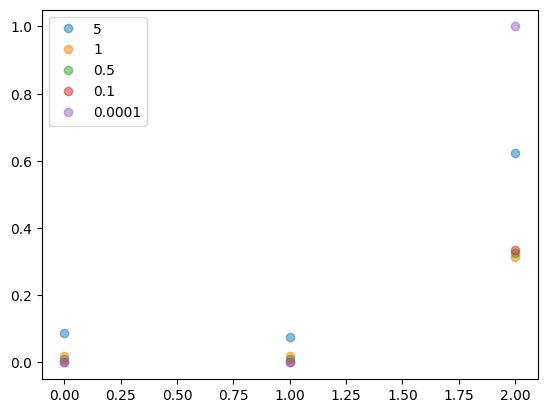

In [185]:
for lam in lams: 
    # for x in mean_gammas[lam]:
    #     plt.plot(x, '.', label=lam)
    #     # print(lam, mean_gammas[lam])
    plt.plot(np.array(mean_gammas[lam]).mean(0).mean(0), 'o', label=lam, alpha=0.5)
    print(lam, np.array(mean_gammas[lam]).mean(0).mean(0))

plt.legend()
plt.ylim(-0.05, 1.05)

In [186]:
mean_gammas_dict = dict()
for i in range(3):
    mean_gammas_dict[i] = dict()

for lam in lams:
    mean_gammas[lam] = np.array(mean_gammas[lam])
    for i in range(3):
        mean_gammas_dict[i][lam] = np.ndarray.flatten(mean_gammas[lam][:, :, i])

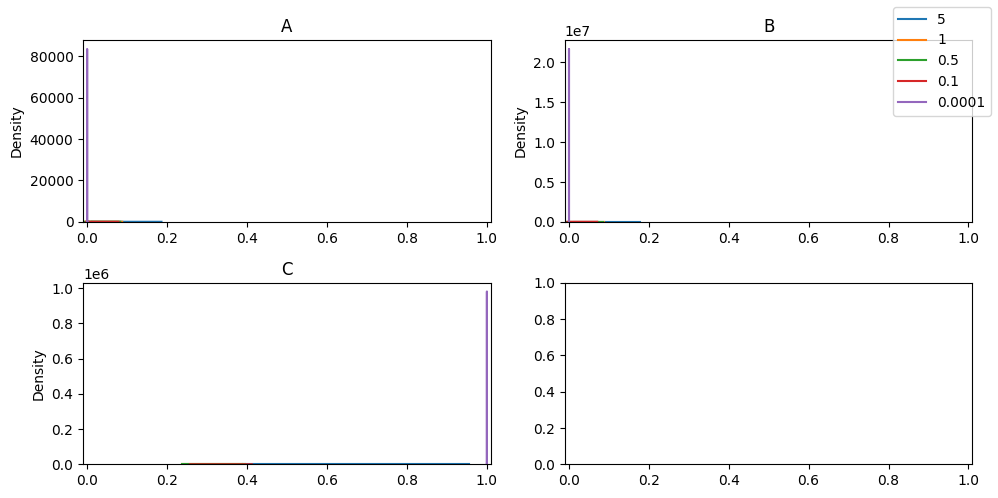

In [187]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 5)

for lam in lams:
    sns.kdeplot(mean_gammas_dict[0][lam], ax=axs[0, 0], label=f'{lam}')
    sns.kdeplot(mean_gammas_dict[1][lam], ax=axs[0, 1])
    sns.kdeplot(mean_gammas_dict[2][lam], ax=axs[1, 0])

for ax in axs.flat:
    ax.set_xlim(-0.01, 1.01)

axs[0, 0].set_title("A")
axs[0, 1].set_title("B")
axs[1, 0].set_title("C")

plt.tight_layout()
fig.legend()

In [188]:
l = mean_gammas[1].mean(0).mean(0)
print(l)
# print(y.keys())
print(sum(jnp.dot(X, l) - y))

[0.01952129 0.01945349 0.31245402]
-1.1920929e-06


In [189]:
# samples_1 = mcmc.get_samples()
# predictive = Predictive(model, samples_1)
# predictions = predictive(random.PRNGKey(1),
#                          alphas = jnp.ones(X.shape[1]),
#                          lam=10000, 
#                          X=X,
#                          y=y)['y']


# for pred in predictions:
#     for lam in predictions[pred]:
#         print(pred, lam, predictions[pred][lam].mean(0))
# # mean_pred = predictions.mean(0)

# # plt.plot(mean_pred, '.')
# # plt.plot(y, '.')

# # print(sum((mean_pred - y)**2))
# print(y)